## Analyse groundtruth results
An example of how to read in results and output the labelled data, some statistics and visuals about categories.

In [1]:
import json
import os
import glob
import logging
from collections import Counter, defaultdict

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
import sys
sys.path.append(os.path.abspath('../'))
from gandt.data import analyse_labels_data

These files should be copied from S3, e.g. using aws CLI:

```aws s3 sync s3://your-bucketk/20200103-wedding-user/labelled/20200103-wedding-user/annotations ../data/external/labelled/20200103-wedding-user/annotations/```

In [3]:
annotation_files = glob.glob('../data/external/labelled/20200103-*/annotations/consolidated-annotation/consolidation-request/iteration-1/*.json')

Read in responses and preprocess

In [4]:
raw_responses = pd.concat([analyse_labels_data.read_responses(x) for x in annotation_files])

Sometimes there are duplicates in label files, so get rid of them, only accept the first response per worker per image

In [5]:
raw_responses = raw_responses.groupby(['worker_id', 'image_filename', 'image_index'], as_index=False).first()

Filter out responses from unreliable workers. `unfiltered_responses` contains data from all workers (useful for debugging), `filtered_responses` contains only data from workers deemed reliable.

In [10]:
unfiltered_responses, filtered_responses = analyse_labels_data.filter_out_unreliable_workers(raw_responses, reliability_threshold=0.8, min_ratings_no=2, min_ratings_prop=0.5)

Select responses which have sufficient agreement from labellers, and ones which need to be relabelled

In [11]:
certain_responses = filtered_responses[filtered_responses['is_label_certain']]

responses_to_relabel = filtered_responses[~filtered_responses['is_label_certain']]

Select only colums which will be useful for training a model, e.g. filename, majority label

In [12]:
certain_responses = certain_responses[['image_filename', 'majority_label']]

## Visualise some results
NB the colour below are just an example that works well for this case (3 binary labels)


Text(0.5, 0, 'Proportion of majority response [%]')

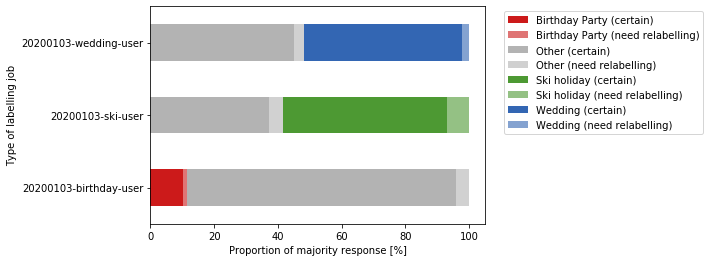

In [13]:
darkred = (0.8, 0.1, 0.1, 1)
lightred = darkred[:3] + (0.6,)
darkgrey = (0.7, 0.7, 0.7, 1)
lightgrey = darkgrey[:3] + (0.6,)
darkgreen = (0.3, 0.6, 0.2, 1)
lightgreen = darkgreen[:3] + (0.6,)
darkblue = (0.2, 0.4, 0.7, 1)
lightblue = darkblue[:3] + (0.6,)

(filtered_responses.groupby(['labelling_job_name'])['majority_label_description'].value_counts(normalize=True) * 100).sort_index().unstack(1).plot.barh(stacked=True, color=[
    darkred, lightred,
    darkgrey, lightgrey,
    darkgreen, lightgreen,
    darkblue, lightblue
])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Type of labelling job')
plt.xlabel('Proportion of majority response [%]')